In [1]:
import nibabel as nib
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt

import config
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

import process_data

In [2]:
def squash(param, p_min, p_max):
    squashed_param_tensor =torch.clamp(param, min=p_min, max=p_max)
    unsqueezed_param = squashed_param_tensor.unsqueeze(1)
    return unsqueezed_param

In [3]:
def unitsphere2cart(theta, phi, X):
    mu_cart = torch.zeros(3,X.size()[0])
    sintheta = torch.sin(theta)
    mu_cart[0,:] = torch.squeeze(sintheta * torch.cos(phi))
    mu_cart[1,:] = torch.squeeze(sintheta * torch.sin(phi))
    mu_cart[2,:] = torch.squeeze(torch.cos(theta))
    return mu_cart

In [4]:
def get_acquisition_scheme():
    bvals = np.loadtxt(
        config.data_folder2 + '/100206/bvals'
    ) * 1e-3
    # s/m^2
    gradient_directions = np.loadtxt(
        config.data_folder2 + '/100206/bvecs'
    ).T

    delta = 0.0106
    Delta = 0.0431
    return acquisition_scheme_from_bvalues(bvals, gradient_directions, delta, Delta)

In [16]:
class BallStickNet(nn.Module):
    
    def __init__(self, gradient_directions, b_values):
        super(BallStickNet, self).__init__()
        self.gradient_directions = gradient_directions
        self.b_values = b_values
        self.fc_layers = nn.ModuleList()
        for i in range(3): 
            self.fc_layers.extend([nn.Linear(len(b_values), len(b_values)), nn.ELU()])
        self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values), 6))
        # if args.dropout != 0:
        #     self.dropout = nn.Dropout(args.dropout)
            
    def forward(self, X):
        # if args.dropout != 0:
        #     X = self.dropout(X)
        params = torch.abs(self.encoder(X))
        theta_uns = params[:, 0]
        # theta = squash(theta_uns, 0, np.pi)
        theta = theta_uns.unsqueeze(1)
        phi_uns = params[:, 1]
        # phi = squash(phi_uns, -np.pi, np.pi)
        phi = phi_uns.unsqueeze(1)
        mu_cart = unitsphere2cart(theta, phi, X)
        mm_prod =  torch.einsum("ij,jk->ki",self.gradient_directions, mu_cart)
        lambda_par_uns = params[:, 2]
        lambda_par = squash(lambda_par_uns, 0.1, 3.0)
        lambda_iso_uns = params[:, 3]
        lambda_iso = squash(lambda_iso_uns, 0.1, 3.0)
        volume_0_uns = params[:, 4]
        volume_0 = squash(volume_0_uns, 0.01, 0.99)
        volume_1 = 1-volume_0
        s0 = params[:, 5].unsqueeze(1)
        X = (volume_0 * torch.exp(-self.b_values * lambda_par * mm_prod ** 2) + volume_1 * torch.exp(-self.b_values * lambda_iso))*s0
        return X, mu_cart, lambda_par, lambda_iso, volume_0, volume_1, s0

In [6]:
# normalized_scan_long_no_background_100206 = np.load('/Users/weiwenhua/UGY4/COMP0029/COMP0029-Project/deep-ivim/normalized_scan_long_1.npy')

In [26]:
normalized_scan_100206.shape

(935439, 288)

In [20]:
scan_100206_long_no_bg.shape

(935442, 288)

In [21]:
bvals = np.loadtxt(config.data_folder2 + '/100206/bvals') * 1e-3

In [22]:
n = np.loadtxt(config.data_folder2 + '/100206/bvecs').T
b_values = torch.FloatTensor(bvals)
gradient_directions = torch.FloatTensor(n)

net = BallStickNet(gradient_directions, b_values)

In [23]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0001)

In [24]:
batch_size = 128
num_batches = len(scan_100206_long_no_bg) // batch_size
trainloader = utils.DataLoader(torch.from_numpy(scan_100206_long_no_bg.astype(np.float32)),
                               batch_size = batch_size, 
                               shuffle = True,
                               num_workers = 2,
                               drop_last = True)

In [ ]:
loss_arr=[]
avg_loss_arr=[]

counter = 0

# Best loss
best = 1e16
num_bad_epochs = 0
patience = 20

for epoch in range(1000):
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        optimizer.zero_grad()
        X_pred, mu_cart_pred, lambda_par_pred, lambda_iso_pred,  volume_0_pred, volume_1_pred, s0_pred = net(X_batch)
        if i == 8 and counter == 10:
            print("X_batch: ")
            print(X_batch.shape)
            print(X_batch)
            print("X_pred: ")
            print(X_pred.shape)
            print(X_pred)
        loss = criterion(X_pred.type(torch.FloatTensor), X_batch.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss_arr.append(running_loss)
    avg_loss_arr.append(running_loss/num_batches)
    print("Loss: {}".format(running_loss))
    print("Average Loss: {}".format(running_loss/num_batches))
    

    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
    counter += 1
print("Done")
net.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 122.00it/s]


Loss: 9703261486.625
Average Loss: 1327758.8241139846
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 156.03it/s]


Loss: 9549607079.8125
Average Loss: 1306733.3168873154
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 153.02it/s]


Loss: 9562901736.125
Average Loss: 1308552.5090483031
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 136.92it/s]


Loss: 9566121217.1875
Average Loss: 1308993.051065613
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:03<00:00, 114.51it/s]


Loss: 9658649571.125
Average Loss: 1321654.2927100437
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:10<00:00, 104.00it/s]


Loss: 9600447114.4375
Average Loss: 1313690.081340654
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 4


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 121.99it/s]


Loss: 9580478119.0625
Average Loss: 1310957.59702552
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 5


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:00<00:00, 121.02it/s]


Loss: 9558396067.75
Average Loss: 1307935.9698617952
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 6


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:58<00:00, 125.63it/s]


Loss: 9560681663.0
Average Loss: 1308248.7223590587
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 7


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:00<00:00, 120.49it/s]


Loss: 9608666259.75
Average Loss: 1314814.759133826
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 8


  0%|▏                                                           | 25/7308 [00:02<07:06, 17.09it/s]

X_batch: 
torch.Size([128, 288])
tensor([[ 998.2991,  263.0444,  240.0929,  ...,  503.6289,  212.5402,
          211.2402],
        [2844.2385, 1534.7358,  395.9506,  ..., 1600.1145, 1345.4735,
          819.5311],
        [3145.1199, 1612.6012, 1001.9720,  ..., 1606.8438, 1353.5314,
         1082.1066],
        ...,
        [3951.0002, 1600.4048, 1317.4968,  ..., 1839.0118, 1124.2045,
          704.8265],
        [4166.5850, 2296.9045, 1273.2030,  ..., 2014.5338,  928.8644,
          944.2108],
        [7481.9448, 1895.8447,  981.1535,  ..., 1844.4680,  994.5725,
          468.3480]])
X_pred: 
torch.Size([128, 288])
tensor([[5.4260e+02, 4.5791e+02, 3.3443e+01,  ..., 1.3140e+02, 5.3563e+02,
         7.8954e-01],
        [1.7527e+03, 1.5741e+03, 1.4071e+03,  ..., 1.2717e+02, 1.3865e+03,
         1.6815e+02],
        [2.0400e+03, 4.2180e+02, 1.1674e+02,  ..., 1.9661e+03, 5.8246e+02,
         8.1168e+01],
        ...,
        [2.4282e+03, 9.9745e+02, 1.6897e+03,  ..., 1.2574e+02, 3.7470e+

100%|█████████████████████████████████████████████████████████| 7308/7308 [01:01<00:00, 118.04it/s]


Loss: 9599824740.875
Average Loss: 1313604.9180179255
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 9


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 122.23it/s]


Loss: 9551737791.75
Average Loss: 1307024.8757183908
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 10


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 128.55it/s]


Loss: 9544818588.3125
Average Loss: 1306078.0772184592
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 133.42it/s]


Loss: 9541500780.875
Average Loss: 1305624.0805795018
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 130.08it/s]


Loss: 9557987311.5625
Average Loss: 1307880.0371596196
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:58<00:00, 124.22it/s]


Loss: 9540532963.875
Average Loss: 1305491.6480398194
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 127.01it/s]


Loss: 9570927344.0
Average Loss: 1309650.7038861522
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 129.47it/s]


Loss: 9598584264.4375
Average Loss: 1313435.1757577313
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 131.18it/s]


Loss: 9556983352.625
Average Loss: 1307742.659089354
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 133.31it/s]


Loss: 9540368487.4375
Average Loss: 1305469.1416854816
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 128.75it/s]


Loss: 9539321232.9375
Average Loss: 1305325.8392087438
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 127.33it/s]


Loss: 9540367133.0
Average Loss: 1305468.9563492064
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:58<00:00, 124.28it/s]


Loss: 9548787981.8125
Average Loss: 1306621.2345118364
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:02<00:00, 117.11it/s]


Loss: 9546419955.875
Average Loss: 1306297.2025006842
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:06<00:00, 110.38it/s]


Loss: 9541148999.9375
Average Loss: 1305575.9441622195
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 4


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:53<00:00, 64.23it/s]


Loss: 9550861794.5625
Average Loss: 1306905.007466133
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 5


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:09<00:00, 105.90it/s]


Loss: 9600276467.875
Average Loss: 1313666.730688971
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 6


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:08<00:00, 107.12it/s]


Loss: 9537688530.25
Average Loss: 1305102.4261425834
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:06<00:00, 109.98it/s]


Loss: 9540233042.0
Average Loss: 1305450.607827039
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:06<00:00, 110.52it/s]


Loss: 9543227539.625
Average Loss: 1305860.3639333607
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:58<00:00, 124.21it/s]


Loss: 9538030382.1875
Average Loss: 1305149.203911809
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:03<00:00, 114.33it/s]


Loss: 9535813346.4375
Average Loss: 1304845.8328458539
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 134.84it/s]


Loss: 9536305913.4375
Average Loss: 1304913.2339131774
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 134.16it/s]


Loss: 9535272035.0
Average Loss: 1304771.7617679255
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 134.11it/s]


Loss: 9536631299.375
Average Loss: 1304957.758535167
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 136.83it/s]


Loss: 9538597779.6875
Average Loss: 1305226.8445111522
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 127.47it/s]


Loss: 9556223708.875
Average Loss: 1307638.7122160646
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 3


 79%|████████████████████████████████████████████▉            | 5765/7308 [00:46<00:12, 124.13it/s]

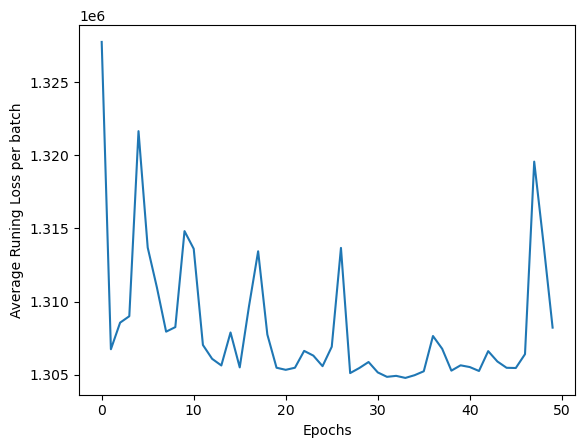

In [28]:
epoch_arr = np.arange(0, len(avg_loss_arr))
loss_arr = np.array(avg_loss_arr)
plt.plot(avg_loss_arr)
plt.xlabel("Epochs")
plt.ylabel("Average Runing Loss per batch")
plt.show()

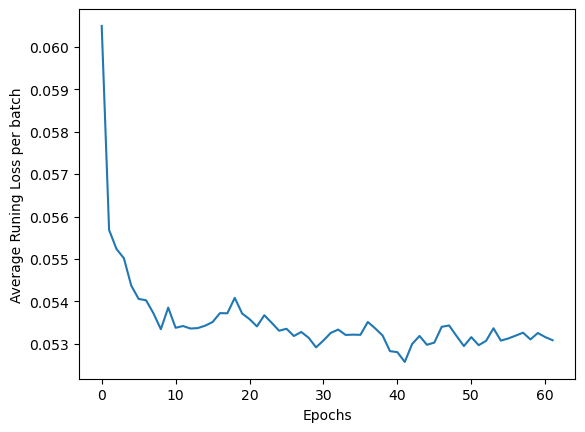

In [40]:
epoch_arr = np.arange(0, len(avg_loss_arr))
loss_arr = np.array(avg_loss_arr)
plt.plot(avg_loss_arr)
plt.xlabel("Epochs")
plt.ylabel("Average Runing Loss per batch")
plt.show()

In [37]:
avg_loss_arr_small_lr = np.load("/Users/weiwenhua/UGY4/COMP0029/COMP0029-Project/deep-ball-stick/loss/avg_loss_for_333e_real_data.npy")

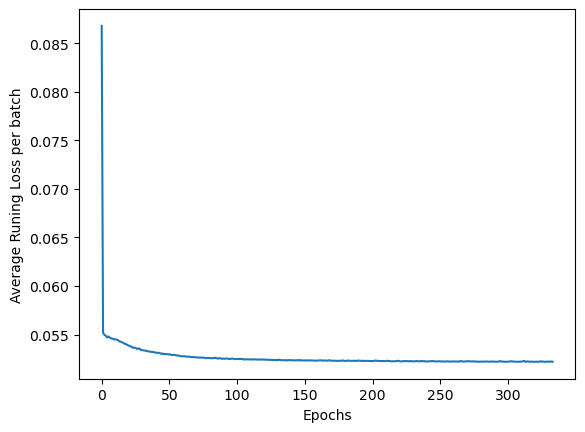

In [33]:
epoch_arr = np.arange(0, len(avg_loss_arr))
loss_arr = np.array(avg_loss_arr)
plt.plot(epoch_arr, avg_loss_arr)
plt.xlabel("Epochs")
plt.ylabel("Average Runing Loss per batch")
plt.show()

In [37]:
np.save("loss_for_333e_real_data.npy", loss_arr)
np.save("avg_loss_for_333e_real_data.npy", avg_loss_arr)

In [38]:
len(loss_arr)

334

In [41]:
torch.save(final_model, 'model_100206_61e.pt')

In [73]:
net.eval()

BallStickNet(
  (fc_layers): ModuleList(
    (0): Linear(in_features=288, out_features=288, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=288, out_features=288, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=288, out_features=288, bias=True)
    (5): ELU(alpha=1.0)
  )
  (encoder): Sequential(
    (0): Linear(in_features=288, out_features=288, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=288, out_features=288, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=288, out_features=288, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=288, out_features=5, bias=True)
  )
)

In [74]:
X_pred_train, mu_cart_pred_train, lambda_par_pred_train, lambda_iso_pred_train,  volume_0_pred_train, volume_1_pred_train = net(torch.from_numpy(normalized_scan_100206.astype(np.float32)))

In [75]:
X_pred_train.shape

torch.Size([935439, 288])

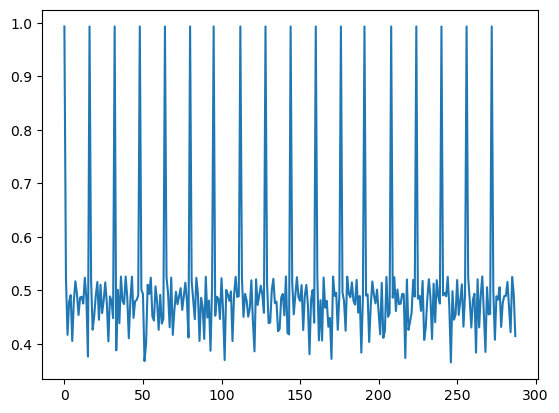

In [104]:
plt.plot(X_pred_train[1,:].detach().numpy())
# plt.plot(X_pred_train[110,:].detach().numpy())
# plt.plot(normalized_scan_100206[1,:])

**Reshape data and remove background voxels**

In [5]:
scan_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/data.nii.gz')

In [6]:
mask_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/nodif_brain_mask.nii.gz')

In [7]:
scan_dimension = scan_100206.shape
x = scan_dimension[0]
y = scan_dimension[1]
z = scan_dimension[2]
b = scan_dimension[3]

In [8]:
print(x, y, z, b)

145 174 145 288


In [9]:
scan_100206_long = np.reshape(scan_100206, (x*y*z, b))

In [10]:
mask_100206_long = np.reshape(mask_100206, (x*y*z, 1))

In [11]:
scan_100206_long_no_background = process_data.trim_background(scan_100206_long, mask_100206_long)

In [12]:
scan_100206_long_no_background.shape

(936256, 288)

In [13]:
# Ignore all strange data

def find_rows_beginning_with_zero(scan_long_no_bg):
    return np.where(scan_long_no_bg[:, 0] == 0)[0]

Sb_beginning_0 = find_rows_beginning_with_zero(scan_100206_long_no_background)

In [14]:
Sb_beginning_0

array([ 46080,  52289,  58710,  61649,  65169,  75865,  77984,  82681,
        88184,  96165,  96248,  98616, 104386, 104471, 105834, 106935,
       112589, 112845, 112930, 115186, 115316, 121280, 121706, 124612,
       127409, 130165, 130591, 132693, 133084, 133597, 137541, 139400,
       139753, 141694, 141918, 142846, 148444, 148806, 149505, 149838,
       151134, 151227, 151272, 152002, 152206, 152349, 152407, 154601,
       156409, 158104, 158288, 158471, 159177, 159511, 160888, 160932,
       161452, 161721, 161983, 161984, 162113, 162132, 162210, 167928,
       168205, 168297, 169004, 169341, 171395, 171798, 171931, 171948,
       172006, 172027, 172164, 172422, 172512, 172608, 172704, 178028,
       178213, 179261, 181980, 182142, 182491, 182588, 182685, 188111,
       188564, 189253, 189586, 191392, 191682, 192585, 192681, 192778,
       198338, 199046, 199391, 199725, 201834, 202277, 202792, 205301,
       208912, 209605, 209942, 211902, 211903, 211904, 212326, 212401,
      

In [15]:
scan_100206_long_no_bg = np.delete(scan_100206_long_no_background, Sb_beginning_0, 0)

**Normalize data**

In [16]:
def get_S0(scan_long, bval_list):
    bval_5_indices = np.where(bval_list == 0.005)[0]
    scan_bval_5 = scan_long[:, bval_5_indices]
    mean_bval_5 = np.mean(scan_bval_5, axis=1)
    mean_bval_5 = mean_bval_5[:, np.newaxis]
    return mean_bval_5

In [19]:
S0_100206 = get_S0(scan_100206_long_no_bg, bvals)

In [20]:
S0_100206

array([[450.87282308],
       [454.07630242],
       [473.0456704 ],
       ...,
       [871.7351515 ],
       [643.40559726],
       [882.28022257]])

In [21]:
error_voxels = np.argwhere(np.logical_and(S0_100206 >= 0, S0_100206 < 1))[:,0]
print(error_voxels)

[229768 536137 850262]


In [22]:
scan_long_no_bg_100206 = np.delete(scan_100206_long_no_bg, error_voxels, 0)
S0_100206_full = np.delete(S0_100206, error_voxels, 0)

In [23]:
scan_long_no_bg_100206.shape

(935439, 288)

In [24]:
normalized_scan_100206 = scan_long_no_bg_100206 / S0_100206_full

In [25]:
np.save('normalized_scan_100206.npy', normalized_scan_100206)

In [ ]:
X_pred_train, mu_cart_pred_train, lambda_par_pred_train, lambda_iso_pred_train,  volume_0_pred_train, volume_1_pred_train

In [100]:
lambda_par_pred_train.shape

torch.Size([935439, 1])

In [85]:
lambda_par_arr = lambda_par_pred_train.detach().numpy()

In [87]:
lambda_par_arr = np.insert(lambda_par_arr, 229768, 0., axis=0)

In [91]:
lambda_par_arr[229768,0]

0.0

In [101]:
print(lambda_par_arr[850265,0])
print(lambda_par_pred_train[850262,0])

0.20945032
tensor(0.2095, grad_fn=<SelectBackward0>)


In [95]:
lambda_par_arr = np.insert(lambda_par_arr, 536137, 0., axis=0)

In [96]:
lambda_par_arr.shape

(935441, 1)

In [97]:
lambda_par_arr = np.insert(lambda_par_arr, 850262, 0., axis=0)

In [102]:
lambda_par_arr.shape

(935442, 1)

In [ ]:
reshape(145,1,145)

In [69]:
bval_5_indices = np.where(bvals == 0.005)[0]
print(bval_5_indices)

[  0  16  32  48  64  80  95 112 128 144 160 176 191 208 224 240 256 272]


In [71]:
scan_bval_5 = scan_100206_long_no_bg[:, bval_5_indices]
print(scan_bval_5)

[[ 587.17718506  409.42816162  470.43640137 ...  340.37411499
   605.80456543  388.1423645 ]
 [ 507.74441528  445.08627319  597.91534424 ...  475.06033325
   395.30215454  638.90899658]
 [ 487.08456421  528.68145752  532.13592529 ...  471.65945435
   254.88105774  486.02966309]
 ...
 [ 812.58972168  789.32568359  799.10009766 ...  825.18902588
  1041.23181152  913.80828857]
 [ 611.19360352  689.40771484  432.87844849 ...  694.77679443
   690.64923096  731.20794678]
 [ 881.83642578  683.88171387  497.27581787 ...  906.99334717
  1008.73608398 1035.60583496]]


In [73]:
mean_bval_5 = np.mean(scan_bval_5, axis=1)
print(mean_bval_5)

[450.87282308 454.07630242 473.0456704  ... 871.7351515  643.40559726
 882.28022257]


In [94]:
c = mean_bval_5.reshape(len(mean_bval_5),1)

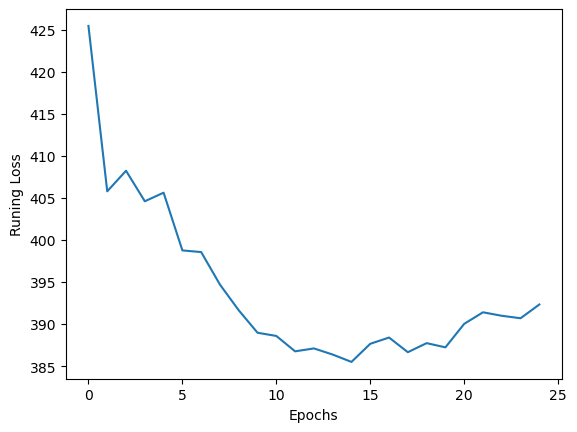

In [12]:
epoch_arr = np.arange(0, len(loss_arr))
loss_arr = np.array(loss_arr)
plt.plot(epoch_arr, loss_arr)
plt.xlabel("Epochs")
plt.ylabel("Runing Loss")
plt.show()

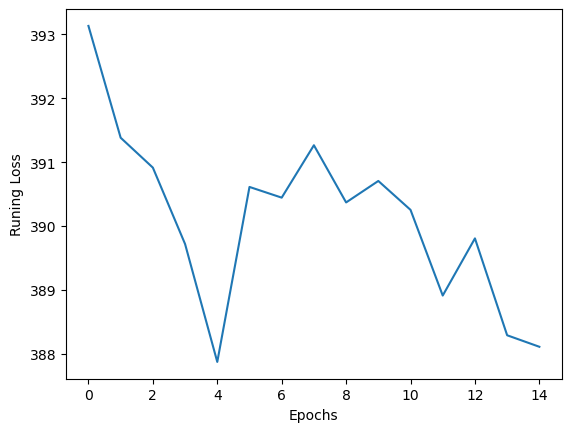

In [19]:
epoch_arr = np.arange(0, len(loss_arr))
loss_arr = np.array(loss_arr)
plt.plot(epoch_arr, loss_arr)
plt.xlabel("Epochs")
plt.ylabel("Runing Loss")
plt.show()

In [13]:
net.eval()

BallStickNet(
  (fc_layers): ModuleList(
    (0): Linear(in_features=288, out_features=288, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=288, out_features=288, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=288, out_features=288, bias=True)
    (5): ELU(alpha=1.0)
  )
  (encoder): Sequential(
    (0): Linear(in_features=288, out_features=288, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=288, out_features=288, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=288, out_features=288, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=288, out_features=5, bias=True)
  )
)

In [14]:
X_pred_train, mu_cart_pred_train, lambda_par_pred_train, lambda_iso_pred_train,  volume_0_pred_train, volume_1_pred_train = net(torch.from_numpy(normalized_scan_long_no_background_100206[0:128,:].astype(np.float32)))

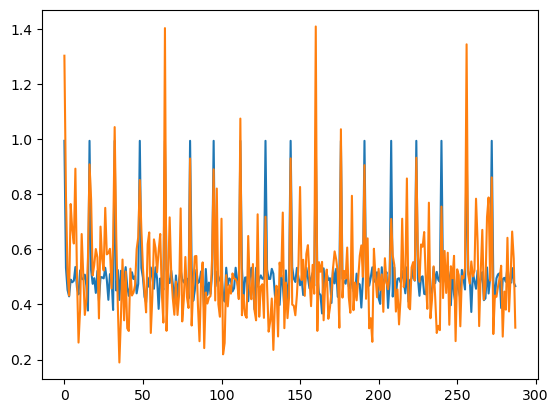

In [17]:
plt.plot(X_pred_train[0,:].detach().numpy())
plt.plot(normalized_scan_long_no_background_100206[0,:])